In [2]:
# WRITTEN BY ALAN LI
# NASA AMES LABORATORY FOR ADVANCED SENSING (LAS)
# Last edited: Aug 10, 2017

import sys
import random
import numpy as np
import cv2
import tensorflow as tf
from matplotlib import pyplot as plt
from collections import Counter

# Config the matplotlib backend as plotting in line in IPython
%matplotlib inline

In [14]:
# Image paths
transect1 = '../Images/Transect 1 Hi-Res.tiff'
transect1_truth = '../Images/Transect 1 Truth data.tif'

# Load images
img1 = cv2.imread(transect1,cv2.IMREAD_UNCHANGED)
img1_truth = cv2.imread(transect1_truth,cv2.IMREAD_UNCHANGED)
                
# Remap truth data
if transect1_truth == '../Images/Transect 1 Truth data.tif':
    img1_truth[img1_truth == 16] = 0  # Sand
    img1_truth[img1_truth == 160] = 1 # Branching
    img1_truth[img1_truth == 198] = 2 # Mounding
    img1_truth[img1_truth == 38] = 3 # Rock

# NOTE: N_images = number of images in a set (e.g. training set, validation set, etc...)
#       N_labels = # of classified pixels associated with an image (i.e. Might want to classify 4 central pixels of a NxN image)
#       num_labels = # of labels (e.g. sand, rock, branching, mounding)
#### Randomize set of data
'''Input:
    dataset: set of images, N_images x (nrow*ncol) x n_channels
    labels: set of labels, N_images x N_labels x num_labels 
Output:
    shuffled_dataset: set of randomized images, N_images x (nrow*ncol) x (n_channels-n_toremove)
    shuffled_labels: set of randomized labels, N_images x N_labels x num_labels
'''
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation,:,:]
    return shuffled_dataset, shuffled_labels    
    
#### Reformat image into input vector style and randomize
'''Input:
    imgset: set of images, N_images x nrow x ncol x n_channels
    toremove: index of channel dimension to remove
    labels: set of labels, N_images x N_labels (N_labels > 1 when we want to classify a number of pixels per image) 
    num_labels: number of possible labels for the entire dataset (4 for morphology, 2 for coral cover)
Output:
    dataset: set of vectorized images, N_images x nrow x ncol x (n_channels-n_toremove)
    labels: set of vectorized labels in the form of logits, N_images x N_labels x num_labels
'''
def reformat(imgset, toremove, labels, num_labels):    
    imgsetcut = imgset
    if toremove is not None:
        imgsetcut = np.delete(imgset,toremove,-1) # Remove specific last dimension of array
    labels = np.asarray([[(np.arange(num_labels) == labels[i,j]).astype(np.float32) for j in range(labels.shape[1])] for i in range(imgsetcut.shape[0])])
    dataset, labels = randomize(imgsetcut, labels)
    return dataset, labels

#### Normalize Image
'''Input:
    dataset: set of vectorized images, N_images x nrow x ncol x n_channels
    depth: pixel depth, float
Output:
    dataset_norm: set of vectorized normalized images, N_images x nrow x ncol x n_channels'''
def rescale(dataset, depth):
    dataset_norm = (dataset.astype(np.float32) - depth/2)/(depth/2)
    return dataset_norm

In [4]:
# Create Training, Validation and Test sets (could probably write a function for this later instead...)

num_labels = 4
image_size = 25 # side length of one sample image
N_train = 20000 # number of training samples per class
N_valid = 2500 # number of validation samples per class
N_test = 2500 # number of test samples per class
crop_len = int(np.floor(image_size/2))
img1_truth_crop = img1_truth[crop_len:img1_truth.shape[0]-crop_len, crop_len:img1_truth.shape[1]-crop_len]

# Randomly select points
train_datasets = []
train_labels = []
valid_datasets = []
valid_labels =[]
test_datasets = []
test_labels = []

for k in range(num_labels):
    [i,j] = np.where(img1_truth_crop == k)
    # Training set
    idx = np.asarray(random.sample(range(len(i)), N_train)).astype(int)
    train_datasets.append([img1[i[idx[nn]]:i[idx[nn]]+image_size, j[idx[nn]]:j[idx[nn]]+image_size, :] for nn in range(len(idx))])
    train_labels.append([img1_truth_crop[i[idx[nn]], j[idx[nn]]] for nn in range(len(idx))])
    # Validation set
    idx = np.asarray(random.sample(range(len(i)), N_valid)).astype(int)
    valid_datasets.append([img1[i[idx[nn]]:i[idx[nn]]+image_size, j[idx[nn]]:j[idx[nn]]+image_size, :] for nn in range(len(idx))])
    valid_labels.append([img1_truth_crop[i[idx[nn]], j[idx[nn]]] for nn in range(len(idx))])
    # Test set
    idx = np.asarray(random.sample(range(len(i)), N_test)).astype(int)
    test_datasets.append([img1[i[idx[nn]]:i[idx[nn]]+image_size, j[idx[nn]]:j[idx[nn]]+image_size, :] for nn in range(len(idx))])
    test_labels.append([img1_truth_crop[i[idx[nn]], j[idx[nn]]] for nn in range(len(idx))])

# Some array handling and reshaping
train_datasets = np.asarray(train_datasets) # train_datasets is in the format of num_labels x N_train x nrows x ncols x n_channels
train_labels = np.asarray(train_labels) # train_labels is in the format of num_labels x N_train
valid_datasets = np.asarray(valid_datasets)
valid_labels = np.asarray(valid_labels) 
test_datasets = np.asarray(test_datasets) 
test_labels = np.asarray(test_labels) 

train_datasets = train_datasets.reshape(num_labels*N_train, image_size, image_size, img1.shape[-1]) # flatten first 2 dimensions of train_datasets
train_labels = train_labels.reshape(num_labels*N_train,1) # flatten into vector
valid_datasets = valid_datasets.reshape(num_labels*N_valid, image_size, image_size, img1.shape[-1]) 
valid_labels = valid_labels.reshape(num_labels*N_valid,1) 
test_datasets = test_datasets.reshape(num_labels*N_test, image_size, image_size, img1.shape[-1]) 
test_labels = test_labels.reshape(num_labels*N_test,1) 

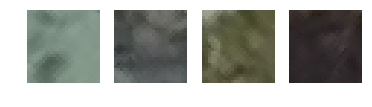

In [5]:
# Plot sample images of different classes
for i in range(num_labels):
    plt.axis("off")
    plt.subplot(1, num_labels, i+1)
    plt.imshow(cv2.cvtColor(train_datasets[i*N_train,:,:,0:3], cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [20]:
depth = 255.0

# More array operations, randomize sets, and normalize from -1 to 1
train_dataset, train_labelset = reformat(train_datasets, 3, train_labels, num_labels) # Reformat shape into batch arrays
valid_dataset, valid_labelset = reformat(valid_datasets, 3, valid_labels, num_labels)
test_dataset, test_labelset = reformat(test_datasets, 3, test_labels, num_labels)
print("Training dataset dimensions: ", train_dataset.shape, "Training labels dimensions: ", train_labelset.shape)
print("Validation dataset dimensions: ", valid_dataset.shape, "Validation labels dimensions: ", valid_labelset.shape)
print("Test dataset dimensions: ", test_dataset.shape, "Test labels dimensions: ", test_labelset.shape)

train_dataset = rescale(train_dataset,depth)
valid_dataset = rescale(valid_dataset,depth)
test_dataset = rescale(test_dataset,depth)

num_channels = train_dataset.shape[-1]
N_labels = train_labelset.shape[1]
print("Num_channels:", num_channels, "N_labels:", N_labels)

Training dataset dimensions:  (80000, 25, 25, 3) Training labels dimensions:  (80000, 1, 4)
Validation dataset dimensions:  (10000, 25, 25, 3) Validation labels dimensions:  (10000, 1, 4)
Test dataset dimensions:  (10000, 25, 25, 3) Test labels dimensions:  (10000, 1, 4)
Num_channels: 3 N_labels: 1


In [ ]:
# Tensorflow Implementation
batch_size = 32
patch1_size = 5
stride1 = 2
patch2_size = 5
stride2 = 1
depth1 = 64
depth2 = 128
depth3 = 256
depth4 = 64

graph = tf.Graph()
with graph.as_default():
    # Datasets
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size*image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape(batch_size,N_labels,num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Size of arrays
    layer1size = (image_size-patch1_size)//stride1 + 1
    layer2size = (conv1size-patch2_size)//stride2 + 1
    
    # Variables
    C1_weights = tf.Variable(tf.truncated_normal([patch1_size, patch1_size, num_channels, depth1], stddev=0.1))
    C1_biases = tf.Variable(tf.zeros([depth1]))
    C2_weights = tf.Variable(tf.truncated_normal([patch2_size, patch2_size, depth1, depth2], stddev=0.1))
    C2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]))
    F3_weights = tf.Variable(tf.truncated_normal([layer2size*layer2size*depth2, depth3], stddev=0.1))
    F3_biases = tf.Variable(tf.constant(1.0, shape=[depth3]))
    F4_weights = tf.Variable(tf.truncated_normal([depth3, depth4], stddev=0.1))
    F4_biases = tf.Variable(tf.constant(1.0, shape=[depth4]))
    F5_weights = tf.Variable(tf.truncated_normal([depth4, N_labels, num_labels], stddev=0.1))
    F5_biases = tf.Variable(tf.constant(1.0, shape=[N_labels,num_labels]))
    
    
    